<a href="https://colab.research.google.com/github/puzzlingConundrum/AutoEncoder-CIFAR10/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

batch_size = 64

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size = batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


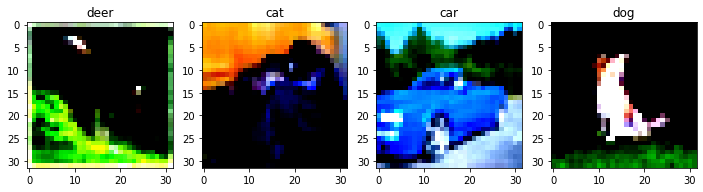

In [4]:
(sample, label) = next(iter(trainloader))

fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(1, 4, i+1)
    plt.imshow(sample[i].permute(1, 2, 0))
    plt.title(f"{classes[label[i]]}")

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, w, h, channel, base_channel_size):
        super(AutoEncoder, self).__init__()
        c_hid = base_channel_size
        self.enc = nn.Sequential(
            nn.Conv2d(channel, c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ConvTranspose2d(c_hid, channel, kernel_size=3, output_padding=1, padding=1, stride=2),            
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.enc(x)
        z = self.pool(z)
        z = self.dec(z)
        return z

In [6]:
epochs = 30
model = AutoEncoder(32, 32, 3, 8).cuda()
print(model)

criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=1E-3)
lambda1 = lambda epoch: 0.99
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim, lr_lambda=lambda1)

AutoEncoder(
  (enc): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): Sigmoid()
  )
)


In [7]:
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0

    for _, (batch, label) in enumerate(trainloader):
        batch = batch.cuda()
        prediction = model(batch)
        loss = criterion(batch, prediction)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item() / batch_size
    
    with torch.no_grad():
        model.eval()
        for _, (batch, label) in enumerate(testloader):
            batch = batch.cuda()
            label = label.cuda()

            prediction = model(batch)
            loss = criterion(batch, prediction)
            
            test_loss += loss.item() / batch_size
    print(f"{epoch+1}/{epochs} :  train_loss = {train_loss/len(trainset):.4f}, test_loss = {test_loss/len(testset):.4f}")

1/30 :  train_loss = 0.0003, test_loss = 0.0002
2/30 :  train_loss = 0.0002, test_loss = 0.0002
3/30 :  train_loss = 0.0002, test_loss = 0.0002
4/30 :  train_loss = 0.0002, test_loss = 0.0002
5/30 :  train_loss = 0.0002, test_loss = 0.0002
6/30 :  train_loss = 0.0002, test_loss = 0.0002
7/30 :  train_loss = 0.0002, test_loss = 0.0002
8/30 :  train_loss = 0.0002, test_loss = 0.0002
9/30 :  train_loss = 0.0002, test_loss = 0.0002
10/30 :  train_loss = 0.0002, test_loss = 0.0002
11/30 :  train_loss = 0.0002, test_loss = 0.0002
12/30 :  train_loss = 0.0002, test_loss = 0.0002
13/30 :  train_loss = 0.0002, test_loss = 0.0002
14/30 :  train_loss = 0.0002, test_loss = 0.0002
15/30 :  train_loss = 0.0002, test_loss = 0.0002
16/30 :  train_loss = 0.0002, test_loss = 0.0002
17/30 :  train_loss = 0.0002, test_loss = 0.0002
18/30 :  train_loss = 0.0002, test_loss = 0.0002
19/30 :  train_loss = 0.0002, test_loss = 0.0002
20/30 :  train_loss = 0.0002, test_loss = 0.0002
21/30 :  train_loss = 0.0002,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Images


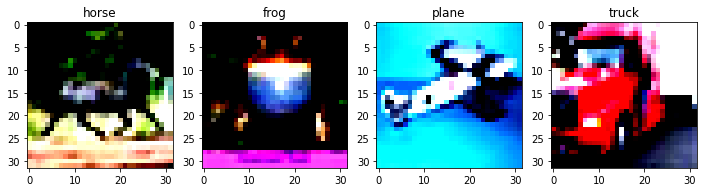

Reconstructed Images


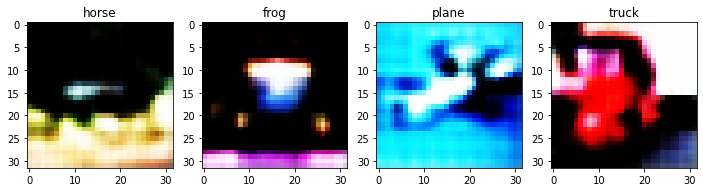

In [8]:
#Batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

#Sample outputs
output = model(images.cuda())
images = images.numpy()

output = output.view(batch_size, 3, 32, 32)
output = output.cpu().detach().numpy()

#Original Images
print("Original Images")
fig = plt.figure(figsize=(12,12))
for idx in np.arange(4):
    fig.add_subplot(1, 4, idx+1)
    plt.imshow(np.transpose(images[idx].reshape(3,32,32), (1,2,0)))
    plt.title(f"{classes[labels[idx]]}")
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig = plt.figure(figsize=(12,12))
for idx in np.arange(4):
    fig.add_subplot(1, 4, idx+1)
    plt.imshow(np.transpose(output[idx].reshape(3,32,32), (1,2,0)))
    plt.title(f"{classes[labels[idx]]}")
plt.show()